<a href="https://colab.research.google.com/github/SVJLucas/Physics-Informed-Features-For-Dark-Matter-Morphology/blob/main/examples/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries:

In [1]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Declaring the PhysicsInformedFeatures Class

In [2]:
class PhysicsInformedFeatures:
  def __init__(self,profile_size,min_angle_vision=-3.232, max_angle_vision=3.232):
    """
    Initialize the PhysicsInformedFeatures.

    This class provides a Physics Informed process to get Features of Gravitational
    Lensing Images.

    Parameters:
        profile_size (int): Size of the image profile (width or height in pixels).
        min_angle_vision (float, optional): Minimum vision angle in arcseconds in the images.
                                            Defaults to -3.232.
        max_angle_vision (float, optional): Maximum vision angle in arcseconds in the images.
                                            Defaults to 3.232.

    Raises:
        ValueError: If profile_size is not a positive integer greater than 1.
        ValueError: If min_angle_vision is greater than or equal to max_angle_vision.
    """

    # Check if the profile_size is a positive integer greater than 1
    if not isinstance(profile_size, int) or profile_size <= 1:
        raise ValueError("profile_size must be a positive integer bigger than 1")

    # Check if min_angle_vision is less than max_angle_vision
    if min_angle_vision >= max_angle_vision:
        raise ValueError("min_angle_vision must be less than max_angle_vision")

    # Store the image profile size, min_angle_vision, and max_angle_vision as class attributes
    self.profile_size = profile_size
    self.min_angle_vision = min_angle_vision
    self.max_angle_vision = max_angle_vision

    # Generate coordinate grids for image positions
    self.x = np.linspace(min_angle_vision, max_angle_vision, profile_size)
    self.y = np.linspace(min_angle_vision, max_angle_vision, profile_size)

    # Calculate the pixel width of the image
    self.pixel_width = self.x[1] - self.x[0]

  def plot_image(self,matrix,title=None,cmap='inferno', show_ticks_multiple_of=30,colorbar=True,axis=False,vmax=None,vmin=None):

    """
    Plot a matrix with customized ticks and visualizations.

    Parameters:
      matrix (numpy.ndarray): The input matrix to be plotted.
      title (str): The title of the plot.
      cmap (str, optional): The colormap to be used for visualization. Defaults to 'inferno'.
      min_angle_vision (float, optional): The minimum angle of vision for ticks. Defaults to -3.232.
      max_angle_vision (float, optional): The maximum angle of vision for ticks. Defaults to 3.232.
      show_ticks_multiple_of (int, optional): The interval for displaying tick marks. Defaults to 30.
      colorbar (bool, optional): A boolean that determines whether to include a colorbar in the graph or not. Defaults to True.
      axis (bool, optional): A boolean that determines whether to include the axis in the graph or not. Defaults to False.
      vmax (float, optional): The maximum value to be used for color normalization. Defaults to None.
      vmin (float, optional): The minimum value to be used for color normalization. Defaults to None.
    """

    # Calculate the center coordinates of the image
    height, width = matrix.shape[:2]
    center_x, center_y = width / 2, height / 2

    # Create tick positions and labels
    x_ticks = np.linspace(self.min_angle_vision, self.max_angle_vision, width+1)
    y_ticks = np.linspace(self.min_angle_vision, self.max_angle_vision, height+1)
    x_tick_labels = np.round(100*x_ticks * center_x/75).astype(int)/100
    y_tick_labels = np.round(100*y_ticks * center_y/75).astype(int)/100

    # Plot the image with centered coordinates and updated ticks
    if vmax is None and vmin is None:
      plt.imshow(matrix, extent=[-center_x, center_x, -center_y, center_y],cmap=cmap)
    elif vmax is not None and vmin is None:
      plt.imshow(matrix, extent=[-center_x, center_x, -center_y, center_y],cmap=cmap,vmax=vmax)
    elif vmax is None and vmin is not None:
      plt.imshow(matrix, extent=[-center_x, center_x, -center_y, center_y],cmap=cmap,vmin=vmin)
    else:
      plt.imshow(matrix, extent=[-center_x, center_x, -center_y, center_y],cmap=cmap,vmax=vmax,vmin=vmin)
    # Set the number of ticks on each axis
    plt.xticks(np.linspace(-center_x, center_y, width+1)[::show_ticks_multiple_of], x_tick_labels[::show_ticks_multiple_of])
    plt.yticks(np.linspace(-center_x, center_y, width+1)[::show_ticks_multiple_of], y_tick_labels[::show_ticks_multiple_of])

    if not axis:
      plt.axis('off')
    if title:
      plt.title(title)
    if colorbar:
      plt.colorbar()
    plt.show()

  def get_sersic_bn_constant(self, n):
    """
    Compute the Sersic index bn constant for the given Sersic index (n).

    The Sersic index (n) characterizes the radial profile of a galaxy or light distribution.
    This function calculates the bn constant used in the Sersic profile formula, which
    relates the Sersic index (n) to the effective radius and surface brightness of a galaxy.

    Parameters:
        n (float): Sersic index. A higher value of n corresponds to a more concentrated profile.

    Returns:
        float: The Sersic index bn constant calculated using the provided Sersic index (n).
    """
    # Calculate the bn constant using the Sersic index (n) formula
    bn = 1.999 * n - 0.327

    return bn

  def sersic_profile(self, x, y, x0=0.0, y0=0.0, theta=0.0, q=0.7522, n=1.0, r_ser=0.30, I0=1.0):
    """
    Generate the intensity distribution of light in an elliptical galaxy using Sersic profile.

    Parameters:
      x, y : 2D numpy arrays denoting the x and y coordinates.
      x0, y0: Floats representing the center of the ellipse.
      theta: Float for the rotation angle in radians.
      q: Float for the axis ratio of the ellipse.
      n: Float for the Sersic index.
      r_ser: Float for the Sersic radius.
      I0: Float for the central surface brightness.

    Returns:
      Is: 2D numpy array representing the intensity distribution.
    """
    # Calculating the radii from the center of the ellipse
    R = np.sqrt(((np.cos(theta)*(x-x0) + np.sin(theta)*(y-y0))**2
                 + (q**2)*((np.sin(theta)*(x-x0) - np.cos(theta)*(y-y0))**2))/q)

    # Calculate the constant bn based on the Sersic index
    bn = self.get_sersic_bn_constant(n)

    # Calculate the intensity at each point (x, y) based on the Sersic profile
    Is = I0*np.exp(-bn*((R/r_ser)**(1/n)))
    return Is

  def residuals(self, params, x, y, sersic_observed):
    """
    Compute the residuals of the observed Sersic profile and the model Sersic profile.

    Parameters:
      params : List of parameters for the Sersic profile [x0, y0, theta, q, n, r_ser].
      x, y : 2D numpy arrays denoting the x and y coordinates.
      sersic_observed : 2D numpy array for the observed Sersic profile.

    Returns:
      residuals : 1D numpy array of residuals.
    """
    x0, y0, theta, q, n, r_ser = params
    sersic_model = self.sersic_profile(x, y, x0, y0, theta, q, n, r_ser, I0=1.0)
    return (sersic_model - sersic_observed).ravel()

  def fit_sersic_profile(self, x, y, sersic_observed, initial_guess):
    """
    Fit a Sersic profile to observed data.

    Parameters:
      x, y : 2D numpy arrays denoting the x and y coordinates.
      sersic_observed : 2D numpy array for the observed Sersic profile.
      initial_guess : List of initial guesses for the parameters [x0, y0, theta, q, n, r_ser].

    Returns:
      optimal_params : List of optimal parameters [x0, y0, theta, q, n, r_ser].
    """
    # Bounds for parameters, q is constrained to be between 0 and 1
    bounds = ([self.min_angle_vision, self.min_angle_vision, 0, 0, 0.5, 0.1],
              [self.max_angle_vision, self.max_angle_vision, np.pi, 1, 10.0, 3.0])
    result = least_squares(self.residuals, initial_guess, args=(x, y, sersic_observed), bounds=bounds)
    return result.x

  def estimate_parameters(self, x, y, source_profile, profile_size):
    """
    Estimate parameters for a given profile.

    Parameters:
        x (numpy.ndarray): The x-coordinates of the profile.
        y (numpy.ndarray): The y-coordinates of the profile.
        source_profile (numpy.ndarray): The source profile to estimate parameters from.
        profile_size (int): The size of the profile.

    Returns:
        tuple: A tuple containing the estimated parameters x0, y0, theta, q, n, and r_ser.
    """
    # Creating a meshgrid of x and y coordinates
    Y, X = np.meshgrid(x, y)

    # Fitting the Sersic profile to the meshgrid data
    x0, y0, theta, q, n, r_ser = self.fit_sersic_profile(X.ravel(), Y.ravel(), source_profile.ravel(), initial_guess=[0, 0, 0, 1, 0.5, 1])

    # Returning the estimated parameters
    return x0, y0, theta, q, n, r_ser

  def reconstruct_source(self, image_profile, normalize = True, k=1):
    """
    Reconstructs the source from an image of a gravitationally lensed object.

    Parameters:
      image_profile (2D np.array): 2D array representing the brightness of the image.
      normalize (bool, optional): If the reconstructed_source must be normalized.  Defaults to True.
      k (float, optional): Gravitational lensing parameter. Defaults to 1.

    Returns:
      reconstructed_source (2D np.array): The reconstructed source image.
    """

    # Check if image_profile.shape[0] and image_profile.shape[1] is equal to profile_size
    if image_profile.shape[0]!=self.profile_size or image_profile.shape[1]!=self.profile_size:
        raise ValueError(f"The shape of the image_profile must be equal to (profile_size,profile_size)=({self.profile_size,self.profile_size})")

    # Calculating the half of the profile size
    half_profile_size = int(self.profile_size / 2)

    # Initialize the array for the image coordinates
    image_coords = []

    # Generate image coordinates based on the profile size and pixel width
    for x_index in range(-half_profile_size, half_profile_size):
        for y_index in range(-half_profile_size, half_profile_size):
            image_coords.append((x_index * self.pixel_width, y_index * self.pixel_width))

    # Initialize the array for the reconstructed source
    reconstructed_source = np.zeros((self.profile_size, self.profile_size))

    # Iterate over all coordinates in the lensed image
    for x_coord, y_coord in image_coords:
        # Skip the center of the lens
        if x_coord != 0 or y_coord != 0:
            # Calculate the new source coordinates using the lens equation
            # Supposing Singular Isothermal Sphere
            x_source = (x_coord - k * x_coord / np.sqrt(x_coord**2 + y_coord**2))
            y_source = (y_coord - k * y_coord / np.sqrt(x_coord**2 + y_coord**2))

            # Convert the source coordinates to index coordinates
            x_source_index = int(((x_source / self.pixel_width) + half_profile_size))
            y_source_index = int(((y_source / self.pixel_width) + half_profile_size))

            x_image_index = int((x_coord / self.pixel_width) + half_profile_size)
            y_image_index = int((y_coord / self.pixel_width) + half_profile_size)

            # Update the pixel value in the reconstructed source
            if reconstructed_source[x_source_index][y_source_index] == 0:
                reconstructed_source[x_source_index][y_source_index] = image_profile[x_image_index][y_image_index]
            else:
                # The Singular Isothermal Sphere can have two images, in this case, we take the average
                reconstructed_source[x_source_index][y_source_index] = (reconstructed_source[x_source_index][y_source_index] + image_profile[x_image_index][y_image_index]) / 2

    if normalize:
      # Normalize the reconstructed source
      reconstructed_source = reconstructed_source / reconstructed_source.max()

    return reconstructed_source

  def parameterize_reconstructed_source(self,reconstructed_source,normalize = True):

    """

    Estimates the parameters of the Sersic profile for a reconstructed galaxy source.

    Parameters:
      reconstructed_source (2D np.array): 2D array of the reconstructed source.
      normalize (bool, optional): If the reconstructed_source must be normalized.  Defaults to True.

    Returns:
      tuple: Estimated Sersic parameters (x0, y0, theta, q, n, r_ser) and the estimated source profile (2D np.array).

    """

    # Check if reconstructed_source.shape[0] and reconstructed_source.shape[1] is equal to profile_size
    if reconstructed_source.shape[0]!=self.profile_size or reconstructed_source.shape[1]!=self.profile_size:
        raise ValueError(f"The shape of the reconstructed_source must be equal to (profile_size,profile_size)=({self.profile_size,self.profile_size})")


    # Estimate parameters using the function 'estimate_parameters'
    x0, y0, theta, q, n, r_ser = self.estimate_parameters(self.x, self.y, reconstructed_source,self.profile_size)

    sersic_parameters = {'x0':x0,'y0':y0,'theta':theta,'q':q,'n':n,'r_ser':r_ser}

    # Get the maximum intensity I0:
    I0 = reconstructed_source.max()

    # Initialize array for storing Sersic profile intensities
    sersic_intensities = []

    # Calculate the Sersic profile for all coordinates
    for x_coord in self.x:
        for y_coord in self.y:
            intensity = self.sersic_profile(x_coord, y_coord, x0, y0, theta, q, n, r_ser, I0=I0)
            sersic_intensities.append(intensity)

    # Convert the list of intensities to a 2D array
    parameterized_source = np.array(sersic_intensities).reshape(self.profile_size, self.profile_size)

    if normalize:
      parameterized_source = parameterized_source/parameterized_source.max()

    return sersic_parameters, parameterized_source

  def compute_gradient_in_one_direction(self, matrix):

      """
      Compute the gradient in one direction (x or y) for the given matrix, using fifth order finite difference.

      Parameters:
          matrix (numpy.ndarray): Input matrix for which the gradient needs to be computed.

      Returns:
          numpy.ndarray: The gradient of the matrix in one direction.
      """

      # The step used to calculate the gradient
      h = self.pixel_width

      # Compute the forward difference for all but the last four rows
      forward_diff = (-25 * matrix[:-4] + 48 * matrix[1:-3] - 36 * matrix[2:-2] + 16 * matrix[3:-1] - 3 * matrix[4:]) / (12 * h)

      # Compute the backward difference for the last four rows
      backward_diff = (25 * matrix[-4:] - 48 * matrix[-5:-1] + 36 * matrix[-6:-2] - 16 * matrix[-7:-3] + 3 * matrix[-8:-4]) / (12 * h)

      # Concatenate the forward and backward differences to get the gradient for the whole matrix
      gradient = np.concatenate((forward_diff, backward_diff), axis=0)

      return gradient

  def compute_gradient(self, matrix):

      """

      Compute the gradient in both x and y directions for the given matrix.

      This function calculates the gradient of the input matrix in both the x and y directions
      using the forward difference method along one direction and its transpose along the other.

      Parameters:
          matrix (numpy.ndarray): Input matrix for which the gradient needs to be computed.

      Returns:
          tuple: A tuple containing two numpy.ndarray objects representing the gradients
                  in the x and y directions, respectively.
      """
      # Compute the gradient in the x direction
      gradient_x = self.compute_gradient_in_one_direction(matrix)

      # Compute the gradient in the y direction
      # To do this, we transpose the matrix to switch the x and y axes,
      # compute the gradient using the same method, then transpose the result back
      gradient_y = self.compute_gradient_in_one_direction(matrix.T).T

      return gradient_x, gradient_y

  def estimate_distorsions_in_gravitational_potential(self, image_profile, serninc_params, post_process=True, quantile=0.985):

      """
      Estimate the distortion in the gravitational potential given an image of a galaxy being lensed
      and the set of Sersic Parameters of this source.

      This method calculates an estimate of the distortion map resulting from the gravitational lensing effect
      on a given galaxy image and its associated Sersic parameters, which describe the light distribution of the galaxy.

      Parameters:
          image_profile (numpy.ndarray): 2D array representing the image profile of the object.
          sersic_params (dict): A dictionary containing the following Sersic parameters:
                                - 'x0' (float): X-coordinate of the center of the light distribution.
                                - 'y0' (float): Y-coordinate of the center of the light distribution.
                                - 'theta' (float): Orientation angle of the light distribution (in radians).
                                - 'q' (float): Axis ratio of the light distribution (minor/major axis).
                                - 'n' (float): Sersic index characterizing the radial profile.
                                - 'r_ser' (float): Effective radius of the light distribution.
          post_process (bool, optional): Whether to apply post-processing for better visualization and preparation
                                          for machine learning models. Defaults to True.
          quantile (float, optional): The quantile value to be used for normalization during post-processing.
                                      Defaults to 0.985.

      Returns:
          numpy.ndarray: The distortion map caused by the gravitational field for the given Sersic parameters.
                          If post_process is True, the map is post-processed for visualization and
                          better machine learning preparation.
      """

      # Check if image_profile.shape[0] and image_profile.shape[1] is equal to profile_size
      if image_profile.shape[0]!=self.profile_size or image_profile.shape[1]!=self.profile_size:
        raise ValueError(f"The shape of the image_profile must be equal to (profile_size,profile_size)=({self.profile_size,self.profile_size})")

      # Extracting Sersic parameters from the input dictionary
      x0 = serninc_params['x0']
      y0 = serninc_params['y0']
      theta = serninc_params['theta']
      q = serninc_params['q']
      n = serninc_params['n']
      r_ser = serninc_params['r_ser']

      # Calculate the maximum pixel value in the image profile
      I0 = image_profile.max()

      # Assign the image profile data to I
      I = image_profile

      # Calculate the Sersic bn constant using the provided Sersic index (n)
      bn = self.get_sersic_bn_constant(n)

      # Calculate the Sersic radius R based on the image profile data and Sersic parameters
      R = (r_ser * ((1 / bn) * np.log(I0 / I)) ** n) ** 2

      # Compute the first derivatives of R in the x and y directions
      Rx, Ry = self.compute_gradient(R)

      # Compute the second derivatives of R in the x direction (Rxx and Rxy)
      Rxx, Rxy = self.compute_gradient(Rx)

      # Compute the second derivatives of R in the y direction (Ryx and Ryy)
      Ryx, Ryy = self.compute_gradient(Ry)

      # Calculate the average of the mixed second derivatives
      gravitational_distorsions = (Rxy + Ryx) / 2

      # Check if post-processing is required
      if not post_process:
          # Return the raw mixed partial derivative without any post-processing
          return gravitational_distorsions
      else:
          # We avoid taking the maximum value for normalization due to the very high values near the singularities
          norm = np.quantile(gravitational_distorsions, quantile)

          # Normalize the mixed partial derivative using the quantile value
          gravitational_distorsions = gravitational_distorsions / norm

          # Saturate the biggest distortion to better see other distortions in the image
          gravitational_distorsions = np.tanh(gravitational_distorsions)

          # Using the absolute value to avoid numerical issues that appear due to the finite difference discretization
          gravitational_distorsions = np.abs(gravitational_distorsions)

          # Return the post-processed convergence map
          return gravitational_distorsions


  def improve_resolution(self, image, final_image_size=150):

      """

      Improve the resolution of an image using interpolation.

      This method increases the resolution of the input image using interpolation,
      thereby improving the image's quality and providing a higher-resolution output.

      Parameters:
          image (numpy.ndarray): 2D array representing the original image.
          final_image_size (int, optional): The desired size of the final image after resolution improvement.
                                            Defaults to 150.

      Returns:
          numpy.ndarray: The improved image with the desired final resolution.
      """

      # Create a 2D interpolator for the input image
      interpolator = interpolate.RectBivariateSpline(self.x, self.y, image)

      # Generate new coordinate grids for the desired final image size
      xi = np.linspace(self.min_angle_vision, self.max_angle_vision, final_image_size)
      yi = np.linspace(self.min_angle_vision, self.max_angle_vision, final_image_size)

      # Interpolate the image at the new coordinate grids to improve resolution
      interpolated_image = interpolator(xi, yi)

      return interpolated_image

  def plot_features(self,image_profile, reconstructed_source, estimated_source_profile, gravitational_distorsions,
                    sersic_params,cmap_source_galaxy='inferno', cmap_distorsions='hot', figsize=(15, 5), main_title=''):
      """
      Plot various features related to gravitational lensing.

      This function plots multiple images related to gravitational lensing to provide visual insights.

      Parameters:
          image_profile (numpy.ndarray): 2D array representing the original gravitational lensing image.
          reconstructed_source (numpy.ndarray): 2D array representing the reconstructed source image.
          estimated_source_profile (numpy.ndarray): 2D array representing the parameterized source image.
          gravitational_distorsions (numpy.ndarray): 2D array representing the distortions in the gravitational potential.
          sersic_params (dict): A dictionary containing the following Sersic parameters:
                                - 'x0' (float): X-coordinate of the center of the light distribution.
                                - 'y0' (float): Y-coordinate of the center of the light distribution.
                                - 'theta' (float): Orientation angle of the light distribution (in radians).
                                - 'q' (float): Axis ratio of the light distribution (minor/major axis).
                                - 'n' (float): Sersic index characterizing the radial profile.
                                - 'r_ser' (float): Effective radius of the light distribution.
          cmap_source_galaxy (str, optional): The colormap to be used for galaxy-related images.
                                              Defaults to 'inferno'.
          cmap_distorsions (str, optional): The colormap to be used for gravitational distortions image.
                                            Defaults to 'hot'.
          figsize (tuple, optional): The size of the plot figure. Defaults to (15, 5).
          main_title (str, optional): The main title to be displayed above the subplots. Defaults to an empty string.
      """

      # Prepare a list of dictionaries containing image data and titles for each image to be plotted
      images = [
          {'img': image_profile, 'cmap': cmap_source_galaxy, 'title': 'Gravitational Lensing Image'},
          {'img': reconstructed_source, 'cmap': cmap_source_galaxy, 'title': 'Reconstructed Galaxy (Source)'},
          {'img': estimated_source_profile, 'cmap': cmap_source_galaxy, 'title': 'Parameterized Sersic Galaxy'},
          {'img': gravitational_distorsions, 'cmap': cmap_distorsions, 'title': 'Distortions in Gravitational Potential'}
      ]

      # Calculate the center coordinates of the image
      height, width = image_profile.shape[:2]
      center_x, center_y = width / 2, height / 2

      # Create tick positions and labels
      x_ticks = np.linspace(self.min_angle_vision, self.max_angle_vision, width)
      y_ticks = np.linspace(self.min_angle_vision, self.max_angle_vision, height)
      x_tick_labels = np.array([int(100 * self.min_angle_vision) / 100, 0, int(100 * self.max_angle_vision) / 100])
      y_tick_labels = np.array([int(100 * self.min_angle_vision) / 100, 0, int(100 * self.max_angle_vision) / 100])

      # Calculate the step size for tick positions
      step_size_x = max(1, len(x_ticks) // 3)
      step_size_y = max(1, len(y_ticks) // 3)

      # Create a 1x4 grid of subplots
      fig, axes = plt.subplots(1, 4, figsize=figsize)

      for i, (ax, image) in enumerate(zip(axes, images)):
          # Plot each image in the corresponding subplot
          ax.imshow(image['img'], cmap=image['cmap'], extent=[-center_x, center_x, -center_y, center_y])
          ax.set_title(image['title'])

          # Set the number of ticks on each axis and corresponding labels
          ax.set_xticks(np.linspace(-center_x, center_y, num=3))
          ax.set_xticklabels(x_tick_labels)

          ax.set_yticks(np.linspace(-center_x, center_y, num=3))
          ax.set_yticklabels(y_tick_labels)
          ax.set_xlabel('x [arcsec]')

          # For the first subplot, add the ylabel, for the rest, hide y-axis
          if i == 0:
              ax.set_ylabel('y [arcsec]')
          else:
              ax.yaxis.set_visible(False)

      # Add the main title above the subplots
      plt.suptitle(main_title,fontweight='bold')

      # Add the additional label to explain the Sersic parameters
      fig.text(0.5, 0.88, 'Estimated Sersic Galaxy Parameters', ha='center', fontsize=11)

      # Extracting parameters from the dictionary
      x0 = sersic_params['x0']

      # The minus the the next line is due to the y-axis be inverted in the optimization
      y0 = -sersic_params['y0']

      theta = sersic_params['theta']
      q = sersic_params['q']
      n = sersic_params['n']
      r_ser = sersic_params['r_ser']

      # Format each variable to have two decimal digits
      x0_str = f"{x0:.2f}"
      y0_str = f"{y0:.2f}"
      theta_str = f"{theta:.2f}"
      q_str = f"{q:.2f}"
      n_str = f"{n:.2f}"
      r_ser_str = f"{r_ser:.2f}"

      # Creating a LaTeX-formatted string
      latex_string = fr"$x_0 = {x0_str}$, $y_0 = {y0_str}$, $\theta = {theta_str}$, $q = {q_str}$, $n = {n_str}$, $R_\mathrm{{ser}} = {r_ser_str}$"

      # Add the additional label below the main title
      fig.text(0.5, 0.85, latex_string, ha='center', fontsize=10)

      plt.show()


# Problem Description

The identification of dark matter through the analysis of dark matter halos using strong gravitational lensing is a promising approach in cosmology. However, due to the limited available data, simulations trained on machine learning models offer a potential solution.


However, even in simulations, in many instances, it becomes complex to differentiate between the potential different gravitational anomalies. In this tutorial, we will gain a better understanding of the physics behind this phenomenon, and from it, obtain better features to train artificial intelligence models.


## Open the data:

In this project, we're dealing with 2 kinds of simulated Substructure of Dark Matter:

* **Axion Dark Matter**: Axions are hypothetical particles suggested as a potential form of dark matter. Unlike typical dark matter candidates, axions are extremely light and weakly interactive with ordinary matter and radiation. They can produce observable effects in the universe like vortices, rotating solutions of field equations.

* **Cold Dark Matter (CDM)**: is a type of slow-moving dark matter proposed to explain various cosmic phenomena. Within the CDM framework, subhalos, or small dense concentrations of dark matter, are treated as "point masses". This simplification allows easier computation by treating them as singularities in the dark matter distribution.


The observable distortions of distant galaxies, known as gravitational lensing, provide an intriguing connection between the types of dark matter and the roles of different galaxies. This phenomenon serves as an illustrative example of how different types of dark matter, despite their elusive nature, can exert gravitational influence and leave noticeable imprints on our observations. Through gravitational lensing, dark matter influences the light path from the source galaxy, causing it to bend around the lensing galaxy. This effect underscores the crucial role of dark matter in determining the large-scale structure of the universe.


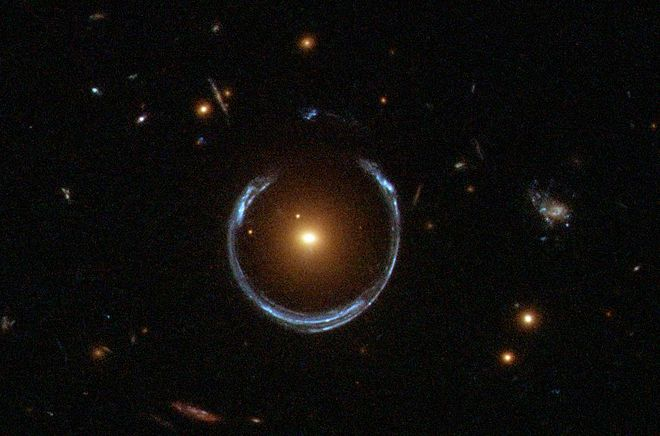

In this figure, taken by the Hubble Space Telescope, the source galaxy (in blue) is the distant celestial body whose light is being bent. On the other hand, the lensing galaxy (in yellow) is the closer body whose gravitational field is causing this light bending. Hence, the lensing galaxy acts as a 'lens' that magnifies and distorts the image of the source galaxy.

In this case, let's simulate 3 cases of Gravitational Lensing:

* **First: Only a Galaxy as Gravitational Lensing and no dark matter.**
* **Second: A Galaxy and CDM as Gravitational Lensing.**
* **Third: A Galaxy and Axion Dark Matter as Gravitational Lensing.**

Let's see the results:

In [3]:
axion_image_profile = np.load('train/sphere/10.npy')
cdm_image_profile = np.load('train/sphere/10.npy')
nosub_image_profile = np.load('train/sphere/10.npy')

axion_image_profile = axion_image_profile.squeeze()
cdm_image_profile = cdm_image_profile.squeeze()
nosub_image_profile = nosub_image_profile.squeeze()

FileNotFoundError: [Errno 2] No such file or directory: 'train/sphere/10.npy'

In [16]:
import cv2

# Assuming your image is loaded in cdm_image_profile
# And you want to resize it to 64x64 pixels

# First, ensure the image is in the correct format (remove extra dimensions if needed)
# Resize the image





In [17]:
def prepro(x):
# Get the dimensions of the image
    height, width = x.shape[:2]

    # Calculate the center of the image
    center_x, center_y = width // 2, height // 2

    # Define the crop size and calculate the start point for cropping
    crop_size = 120
    start_x = center_x - crop_size // 2
    start_y = center_y - crop_size // 2

    # Crop the image
    cropped_image = x[start_y:start_y+crop_size, start_x:start_x+crop_size]
    return cropped_image

In [18]:
axion_image_profile = prepro(axion_image_profile)
cdm_image_profile = prepro(cdm_image_profile)
nosub_image_profile = prepro(nosub_image_profile)


Let's plot:

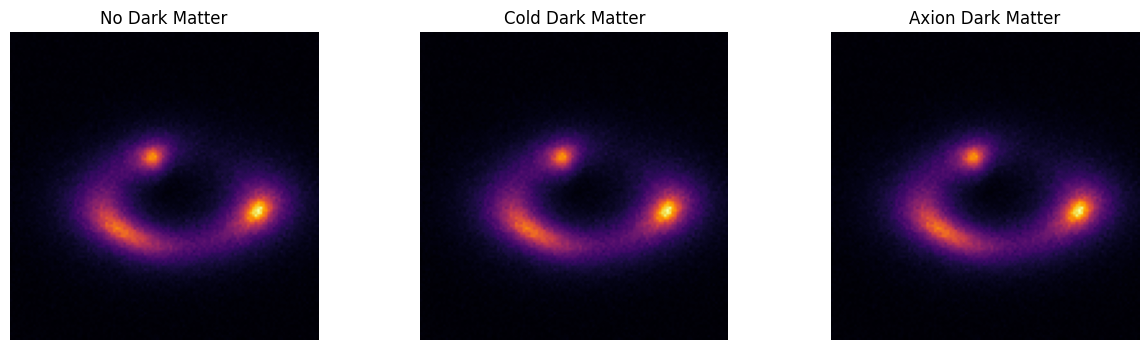

In [19]:
# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15,4))

images = [{'kind':'No Dark Matter','img':nosub_image_profile},
          {'kind':'Cold Dark Matter','img':cdm_image_profile},
          {'kind':'Axion Dark Matter','img':axion_image_profile}]

for i, (ax, image) in enumerate(zip(axes, images)):
    # Plot each image in the corresponding subplot
    ax.imshow(image['img'],cmap='inferno')
    ax.set_title(image['kind'])
    ax.axis('off')
plt.show()

As can be seen, distinguishing among different types of dark matter, or even between the presence or absence of dark matter in observations, can be a complex task, even for a trained eye. This is why we attempt to use automation with machine learning. However, we will also try to understand the physics of the involved phenomenon to improve the classifications.

# Physics Informed Features Module

Here we introduce the new PhysicsInformedFeatures Module, designed to extract new features from images of astronomical simulations, thereby simplifying the classification process.

Now, the new module performs the following tasks:

* **Reconstructs the source galaxy image**: This task is based on the hypothesis that the gravitational effects of dark matter are negligible in most regions of space, and that the lensing galaxy can be approximated by a Singular Isothermal Sphere.

* **Obtains the approximate parameters of the Sersic Profile of the source galaxy**: Upon reconstructing the source galaxy, an attempt is made to approximate it with a Sersic profile, and the parameters of this distribution are obtained.

* **Gravitational Anomalies Reconstruction**: Using the source galaxy profile and the Sersic approximation, we can derive the profile of gravitational distortions based on the differences in intensity and the estimated Sersic profile.

* **Resize the images**: The module does interpolation to resize the given images to get better resolution.

* **Plotting of Results**: The module itself comes equipped with functions to facilitate the plotting of results.

Let's start the module, but, first, we need to set some parameters used in the simulations:

 - Size of the image profile (width or height in pixels): in our case, the image has format (64,64) and then profile_size = 64.

 - Minimum vision angle in arcseconds in the images: in our case, it was used min_angle_vision = -3.232.

 - Maximum vision angle in arcseconds in the images: in our case, it was used max_angle_vision = +3.232.


In [23]:
physics = PhysicsInformedFeatures(profile_size = 120, min_angle_vision = -3.232, max_angle_vision = 3.232)

**Now, let's exemplify these functions by applying them to the Cold Dark Matter (CDM) image.**

## Reconstruction of the Source Galaxy

The equation for gravitational lensing, in its dimensionless form, can be given by the following relation:

\begin{align}
\mathcal{S}(x_s,y_s) = \mathcal{I}(x_i,y_i) - \nabla Ψ(x_i,y_i)
\end{align}

In this equation, $\mathcal{S}(x_s,y_s)$ represents the dimensionless source vector position in the source plane, which corresponds to the position of the source galaxy. On the other hand, $\mathcal{I}(x_i,y_i)$ represents the dimensionless image vector position in the image plane, which corresponds to the image we observe. Finally, $\nabla Ψ(x_i,y_i)$ represents the gradient of the dimensionless gravitational potential produced by the lens, which in our case, includes both the lensing galaxy and the possible dark matter.

Observe that this equation involves three unknowns: the source position $\mathcal{S}$, the image position $\mathcal{I}$, and the gravitational potential of the system $\nabla Ψ(x_i,y_i)$. Yet, we only have knowledge of the produced image $\mathcal{I}$.

In order to estimate the position of the source galaxy, we need to make several assumptions about the potential of the system (i.e., the lensing galaxy plus dark matter). These are as follows:

The gravitational potential can be computed by:

\begin{align}
Ψ(x_i,y_i) = Ψ_{Galaxy}(x_i,y_i) + Ψ_{DarkMatter}(x_i,y_i)
\end{align}

The distortions caused by dark matter are localized and can be ignored in most of the formed image. Therefore, we will approximate:

\begin{align}
Ψ(x_i,y_i) \approx Ψ_{Galaxy}(x_i,y_i)
\end{align}

Given that we don't know the profile of the galaxy, we will assume a Singular Isothermal Sphere (SIS) model, with a proportionality parameter $k$ to correct potential distortions.

\begin{align}
Ψ_{Galaxy}(x_i,y_i) \approx k \cdot \sqrt{x_i^2+y_i^2}
\end{align}

Hence:

\begin{align}
Ψ(x_i,y_i) \approx k \cdot \sqrt{x_i^2+y_i^2}
\end{align}

By imposing a potential profile, we can now estimate the source position. We must then estimate the value of the constant $k$. For the simulation (DeepLens Models I, II, III), a value of $k \approx 1$ works well.

Following this process, we are able to obtain a reconstructed image $\hat{I}_{\hat{\mathcal{S}}}(x_s,y_s)$: the light intensity of the source galaxy given the position $(x_s,y_s)$ in the source plane.

In [24]:
cdm_reconstruct_source = physics.reconstruct_source(cdm_image_profile,k=1)

We can then see the results:

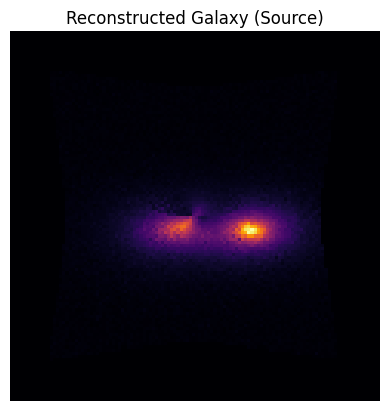

In [25]:
physics.plot_image(cdm_reconstruct_source, title='Reconstructed Galaxy (Source)',colorbar=False,axis=False)

## Approximate the Source Galaxy as the Sersic Profile

The Sersic profile is a mathematical function that describes how the intensity I of the light emitted by a galaxy varies with the distance R from its center. It is widely used in astronomy to characterize the radial brightness profiles of galaxies.

The Sersic profile, for the Source, is given by the formula:


\begin{align}
I_S(x_s,y_s) = I_0 \cdot \exp \left( -b_n \cdot \left(\frac{R(x_s,y_s)}{R_{ser}}\right)^{1/n} \right)
\end{align}

Here, $I_S$ is the intensity at each point (x, y) based on the Sersic profile of the Source Galaxy, $n$ is the Sersic index of the Galaxy, $R_{ser}$ is the Sersic radius of the Galaxy, $I_0$ is the central surface brightness, $b_n$ related to the  Sersic index $n$ and it is given by:


\begin{align}
b_n \approx 1.999 \cdot n - 0.327
\end{align}


Besides, $R$ is the radii from the center of the ellipse given by:

\begin{align}
R(x_s,y_s) = \frac{1}{q}\sqrt{\frac{{(\cos(\theta) \cdot (x_s-x_0) + \sin(\theta) \cdot (y_s-y_0))^2}}{q^2} + \big({\sin(\theta) \cdot (x_s-x_0) - \cos(\theta) \cdot (y_s-y_0)}\big)^2}
\end{align}

Where  $x_0$ and $y_0$ are the center of the ellipse, $\theta$ is the rotation angle, the axis ratio $q$ (eccentricity).

To find these parameters, we can do first:

\begin{align}
I_0 = max_{x_s,y_s}\Big( I_S(x_s,y_s) \Big)
\end{align}


Then, we can use the reconstructed galaxy and minimize the error of the model and the galaxy itself:

\begin{align}
x_0^*,y_0^*,\theta^*,q^*,n^*,R_{ser}^* = \text{minimize}\ \Sigma _{x_s,y_s} ||sersic_{model}(x_s,y_s,x_0,y_0,\theta,q,n,R_{ser},I_0) - sersic_{observed}(x_s,y_s)||^2
\end{align}

And then:

\begin{align}
\boxed{x_0^{*},y_0^{*},\theta^{*},q^{*},n^{*},R_{ser}^{*} = \text{minimize}\ \Sigma_{x_s,y_s} ||I_S(x_s,y_s|x_0,y_0,\theta,q,n,R_{ser},I_0) - \hat{I}_{\hat{\mathcal{S}}}(x_s,y_s)||^2}
\end{align}



With this, we are able to estimate a refined version of the source galaxy.

In [26]:
sersic_params, cdm_estimated_source_profile = physics.parameterize_reconstructed_source(cdm_reconstruct_source)

Let's see the fitted parameters:

In [27]:
x0, y0, theta, q, n, r_ser = sersic_params.values()
print(f'x0={x0}, y0={y0}, theta={theta}, q={q}, n={n}, r_ser={r_ser} ')

x0=0.26104757407587803, y0=0.8162593634088748, theta=0.009151387682839565, q=0.30379918505920306, n=1.2586032558547595, r_ser=0.8958518707747193 


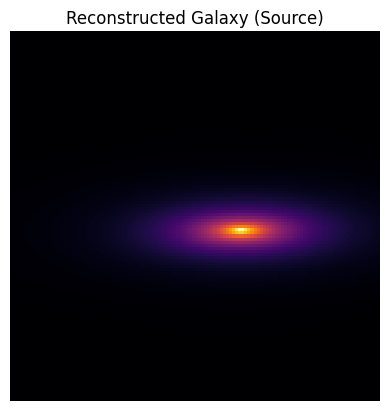

In [28]:
physics.plot_image(cdm_estimated_source_profile,title='Reconstructed Galaxy (Source)',colorbar=False,axis=False)

## Gravitational Anomalies Reconstruction

Now that we have an estimated clean version of the source galaxy, we can use the obtained parameters to find an **Anisotropic Eikonal Partial Differential Equation** that allows us to obtain the potential:

\begin{align}
∇P(x_i,y_i)^T Z(\theta, q) ∇P(x_i,y_i) = \frac{R_{ser}^2}{b_n^{2n}}ln^{2n}\Bigg(\frac{I_0}{I_{\mathcal{I}}(x_i,y_i)}\Bigg)
\end{align}

With the boundary condition of:

\begin{align}
P(0,0) = 0
\end{align}

Where $Z(\theta, q) \in \mathbb{R}^{2\times2}$ is a positive definite matrix that only depends on $\theta$ and $q$ and $I_{\mathcal{I}}(x_i,y_i)$ is the light intensity of the formed image, and, then, the image itself.

Moreover, we define:

\begin{align}
\Psi(x_i,y_i) = \frac{x_i^2+y_i^2}{2}-P(x_i,y_i)-(x_0x_i+y_0y_i)
\end{align}

To avoid solving the partial differential equation, since we only wish to get a glimpse of the distortions, we can do:

\begin{align}
∇\Psi(\vec{x_i}) = \vec{x_i}-∇P(\vec{x_i})-\vec{x_0}
\end{align}

\begin{align}
∇\Psi(\vec{x_i}) + ∇P(\vec{x_i})= \vec{x_i}-\vec{x_0}
\end{align}

Therefore, if the gradient $∇\Psi(\vec{x_i})$ changes abruptly (and therefore near a dark matter singularity) near a given point $\vec{x_i}$, then $∇P(\vec{x_i})$ will also change abruptly, in the opposite direction, to mantain the equality $∇\Psi(\vec{x_i}) + ∇P(\vec{x_i})= \vec{x_i}-\vec{x_0}$, which is approximately constant near $\vec{x_i}$. The product, therefore, $∇P(x_i,y_i)^T Z(\theta, q) ∇P(x_i,y_i)$ should also change abruptly, once $∇P(x_i,y_i)$ itself change abruptly,  which leads to the function:

\begin{align}
\boxed{\mathcal{F}(x_i,y_i) = \frac{R_{ser}^2}{b_n^{2n}}ln^{2n}\Bigg(\frac{I_0}{I_{\mathcal{I}}(x_i,y_i)}\Bigg)}
\end{align}

Changing abruptly as well. To find gravitational distortion points, we simply find the derivatives of the function $\mathcal{F}$ on both the x and y axes. Once our image has very low resolution, we'll use fifth-order finite difference to approximate the derivative:


\begin{align}
f'_i \approx \frac{-25f_i + 48f_{i+1} - 36f_{i+2} + 16f_{i+3} - 3f_{i+4}}{12h}
\end{align}



Thus, the anomaly image can be obtained by:

\begin{align}
\mathcal{A}_{raw}(x_i,y_i) = \frac{ \partial^2 \mathcal{F}}{\partial x \partial y}(x_i,y_i)
\end{align}

However, to better visualize the final result, avoiding numerical errors due to the high absolute values of the potential near the singularities, as well as numerical errors in the calculation of the derivatives, we will make a post process by doing the following transformation:

\begin{align}
\mathcal{A}(x_i,y_i) = \Bigg|Tanh\Bigg(\frac{1}{F_Q}\frac{ \partial^2 \mathcal{F}}{\partial x \partial y}(x_i,y_i)\Bigg)\Bigg|
\end{align}

Where $F_Q$ is a normalization constant.

You can get any of $\mathcal{A}_{raw}(x_i,y_i)$ or $\mathcal{A}(x_i,y_i)$ just changing the boolean *post_process* in the next function.

In [29]:
cdm_gravitational_distorsions = physics.estimate_distorsions_in_gravitational_potential(cdm_image_profile,sersic_params,post_process=True)

C:\Users\harsh\AppData\Local\Temp\ipykernel_26676\3971049277.py:400: RuntimeWarning: divide by zero encountered in divide
  R = (r_ser * ((1 / bn) * np.log(I0 / I)) ** n) ** 2
C:\Users\harsh\AppData\Local\Temp\ipykernel_26676\3971049277.py:313: RuntimeWarning: invalid value encountered in add
  forward_diff = (-25 * matrix[:-4] + 48 * matrix[1:-3] - 36 * matrix[2:-2] + 16 * matrix[3:-1] - 3 * matrix[4:]) / (12 * h)
C:\Users\harsh\AppData\Local\Temp\ipykernel_26676\3971049277.py:313: RuntimeWarning: invalid value encountered in subtract
  forward_diff = (-25 * matrix[:-4] + 48 * matrix[1:-3] - 36 * matrix[2:-2] + 16 * matrix[3:-1] - 3 * matrix[4:]) / (12 * h)
C:\Users\harsh\AppData\Local\Temp\ipykernel_26676\3971049277.py:316: RuntimeWarning: invalid value encountered in subtract
  backward_diff = (25 * matrix[-4:] - 48 * matrix[-5:-1] + 36 * matrix[-6:-2] - 16 * matrix[-7:-3] + 3 * matrix[-8:-4]) / (12 * h)
C:\Users\harsh\AppData\Local\Temp\ipykernel_26676\3971049277.py:316: RuntimeWar

Let's see the results:

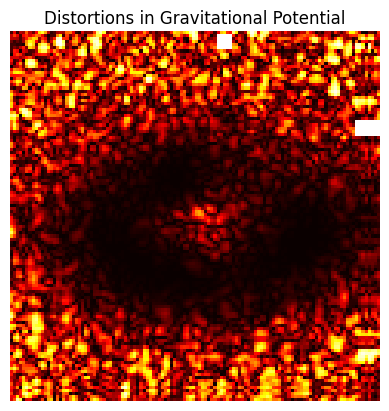

In [30]:
physics.plot_image(cdm_gravitational_distorsions,title='Distortions in Gravitational Potential',colorbar=False,axis=False,cmap='hot')

Remarkable! Now we have the ability to visualize the locations within the image where compact, dense concentrations of Cold Dark Matter (CDM) are situated.

## Resize the images

Now we got gravitational distorsions, we can up-scale it to get better resolution:

In [31]:
cdm_gravitational_distorsions_better_resolution = physics.improve_resolution(cdm_gravitational_distorsions)

Let's see the new version of the previous plot:

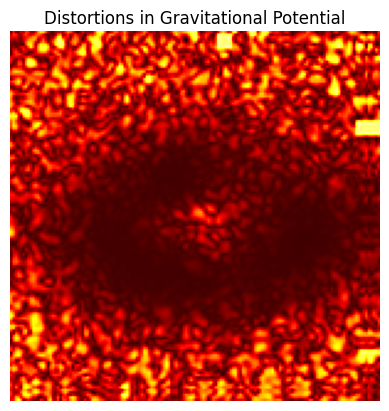

In [32]:
physics.plot_image(cdm_gravitational_distorsions_better_resolution,title='Distortions in Gravitational Potential',colorbar=False,axis=False,cmap='hot')

## Plotting of Results

The module contains two plotting functions:

- *plot_image*: Plots a matrix with customized ticks and visualizations.

- *plot_features*: Plots all the features obtained during the pipeline, from the images to the variables of the Sersic profile.

So far, we have seen how to plot an image separately using the *plot_image* function, let's plot with the *plot_features* function:

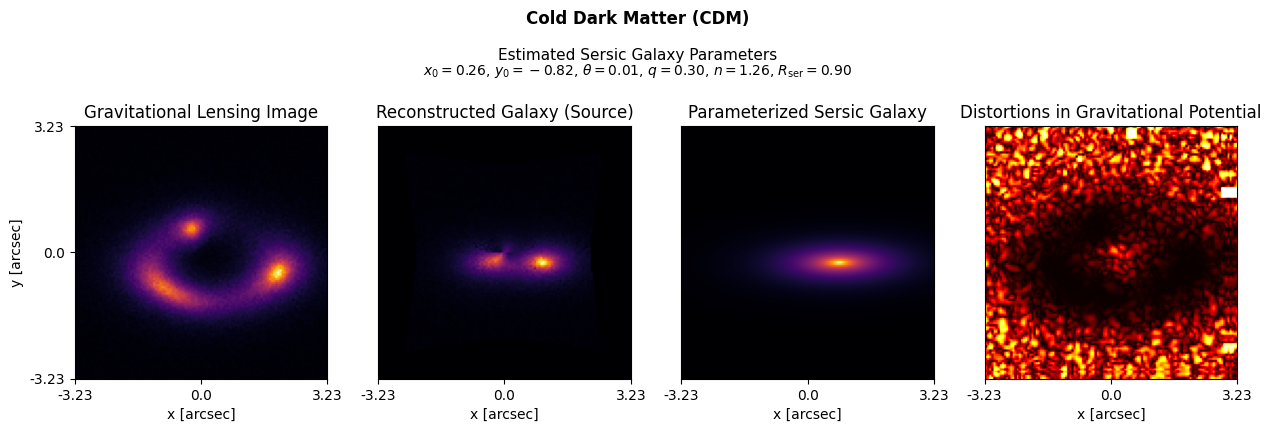

In [33]:
physics.plot_features(cdm_image_profile,
                      cdm_reconstruct_source,
                      cdm_estimated_source_profile,
                      cdm_gravitational_distorsions,
                      sersic_params,
                      main_title = 'Cold Dark Matter (CDM)')

# Putting It All Together

Now that we have examined how the functions in the module have been implemented, we can compile all these functions and verify if we can distinguish the initial images based on the features created.

In doing so, we may remember the following:

- **No Substructure**: The distortion will be centered on the galaxy acting as a lens. Therefore, once we are aligned, it will be near the center of the image.

- **Axion Dark Matter**: They can produce observable effects such as vortices, which result in gravitational distortions appearing as "lines".

- **Cold Dark Matter (CDM)**: Small dense concentrations of dark matter are treated as "point masses," producing gravitational distortions in different locations on the image and in a circular fashion.


Let's open the images:

In [36]:
axion_image_profile = np.load('axion.npy')
cdm_image_profile = np.load('cdm.npy')
nosub_image_profile = np.load('nosub.npy')


axion_image_profile.shape

(64, 64)

Let's plot them:

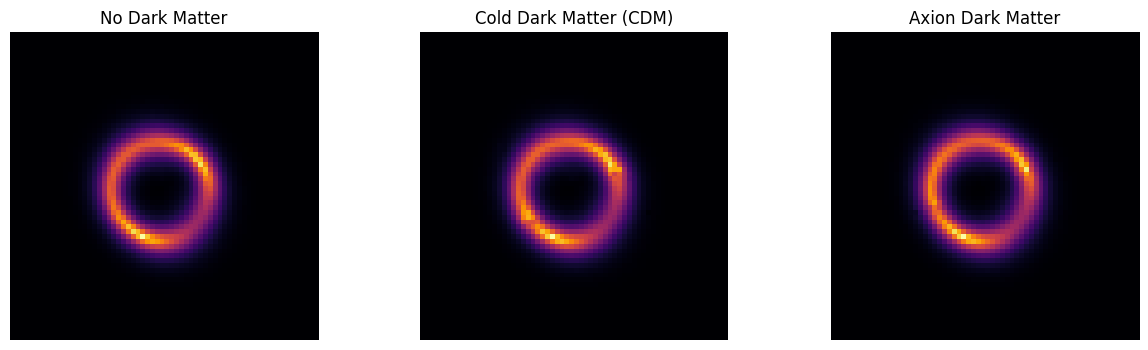

In [37]:
# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15,4))

images = [{'kind':'No Dark Matter','img':nosub_image_profile},
          {'kind':'Cold Dark Matter (CDM)','img':cdm_image_profile},
          {'kind':'Axion Dark Matter','img':axion_image_profile}]

for i, (ax, image) in enumerate(zip(axes, images)):
    # Plot each image in the corresponding subplot
    ax.imshow(image['img'],cmap='inferno')
    ax.set_title(image['kind'])
    ax.axis('off')
plt.show()

As can be seen, distinguishing among different types of dark matter, or even between the presence or absence of dark matter in observations, can be a complex task, even for a trained eye. Let's use **PhysicsInformedFeatures** module.

Let's start the module, but, first, we need to set some parameters used in the simulations:

 - Size of the image profile (width or height in pixels): in our case, the image has format (64,64) and then profile_size = 64.

 - Minimum vision angle in arcseconds in the images: in our case, it was used min_angle_vision = -3.232.

 - Maximum vision angle in arcseconds in the images: in our case, it was used max_angle_vision = +3.232.


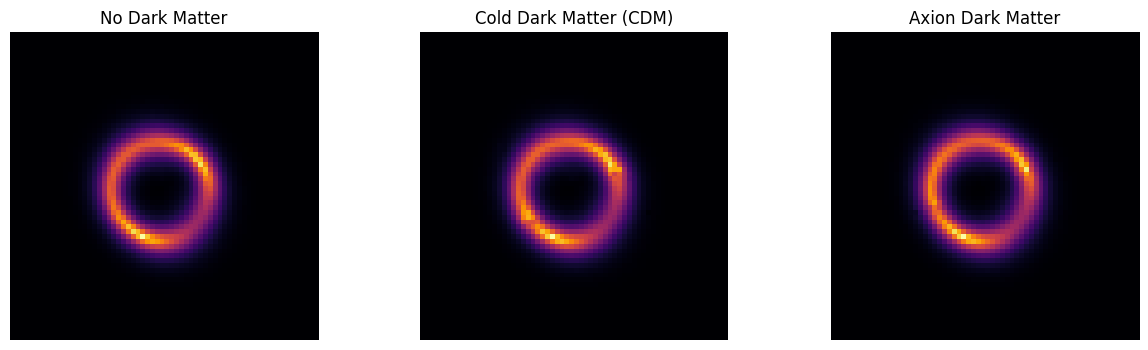

In [38]:
axion_image_profile = np.load('./train/sphere/10.npy')
cdm_image_profile = np.load('./train/sphere/10.npy')
nosub_image_profile = np.load('./train/sphere/10.npy')

axion_image_profile = axion_image_profile.squeeze()
cdm_image_profile = cdm_image_profile.squeeze()
nosub_image_profile = nosub_image_profile.squeeze()
# axion_image_profile = axion_image_profile.squeeze()
# cdm_image_profile = cdm_image_profile.squeeze()
# nosub_image_profile = nosub_image_profile.squeeze()


# # axion_image_profile = prepro(axion_image_profile)
# # cdm_image_profile = prepro(cdm_image_profile)
# # nosub_image_profile = prepro(nosub_image_profile)
# axion_image_profile = cv2.resize(axion_image_profile, (64, 64), interpolation=cv2.INTER_AREA)
# cdm_image_profile = cv2.resize(cdm_image_profile, (64, 64), interpolation=cv2.INTER_AREA)
# nosub_image_profile = cv2.resize(nosub_image_profile, (64, 64), interpolation=cv2.INTER_AREA)



# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15,4))

images = [{'kind':'No Dark Matter','img':nosub_image_profile},
          {'kind':'Cold Dark Matter (CDM)','img':cdm_image_profile},
          {'kind':'Axion Dark Matter','img':axion_image_profile}]

for i, (ax, image) in enumerate(zip(axes, images)):
    # Plot each image in the corresponding subplot
    ax.imshow(image['img'],cmap='inferno')
    ax.set_title(image['kind'])
    ax.axis('off')
plt.show()


physics = PhysicsInformedFeatures(profile_size = 64, min_angle_vision = -3.232, max_angle_vision = 3.232)

Let's extract the features from the images:

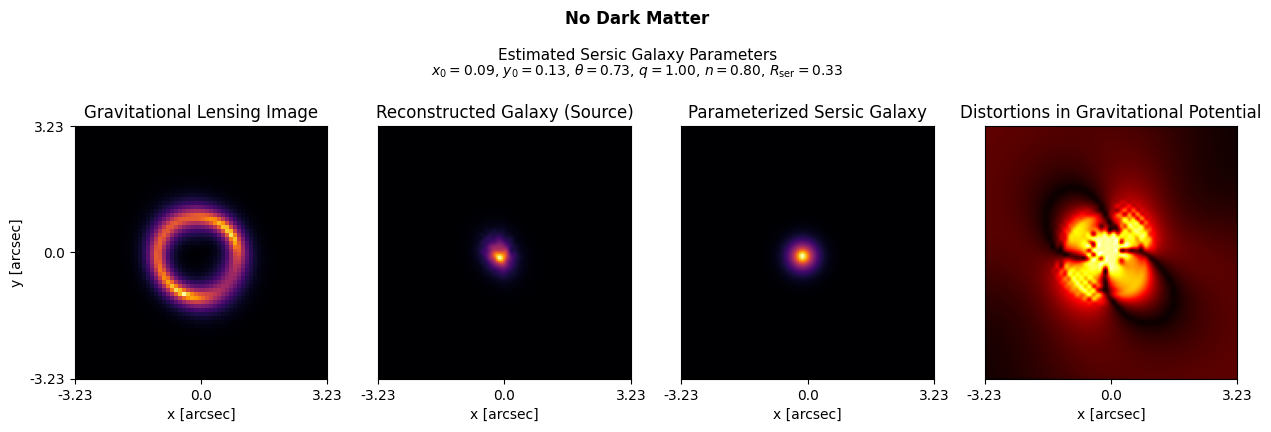

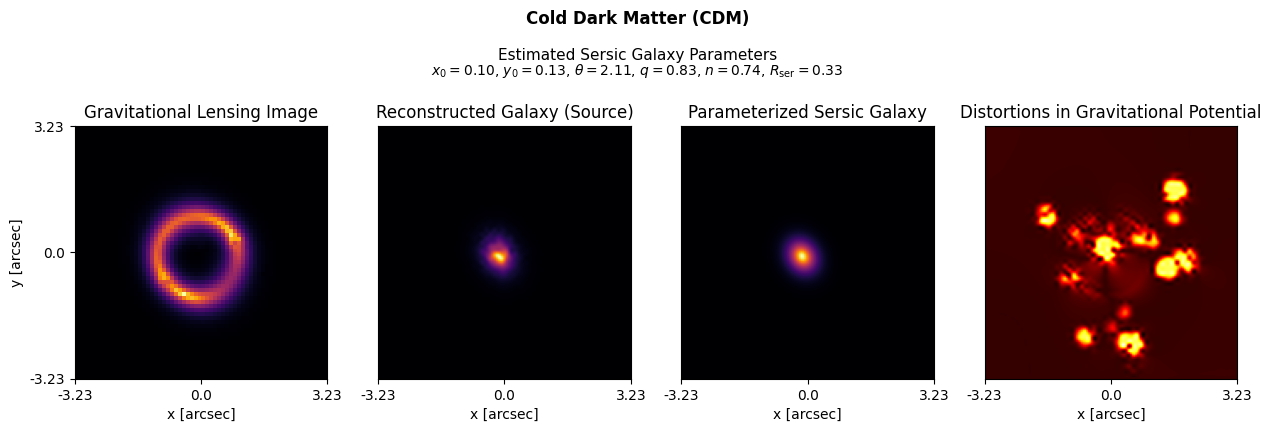

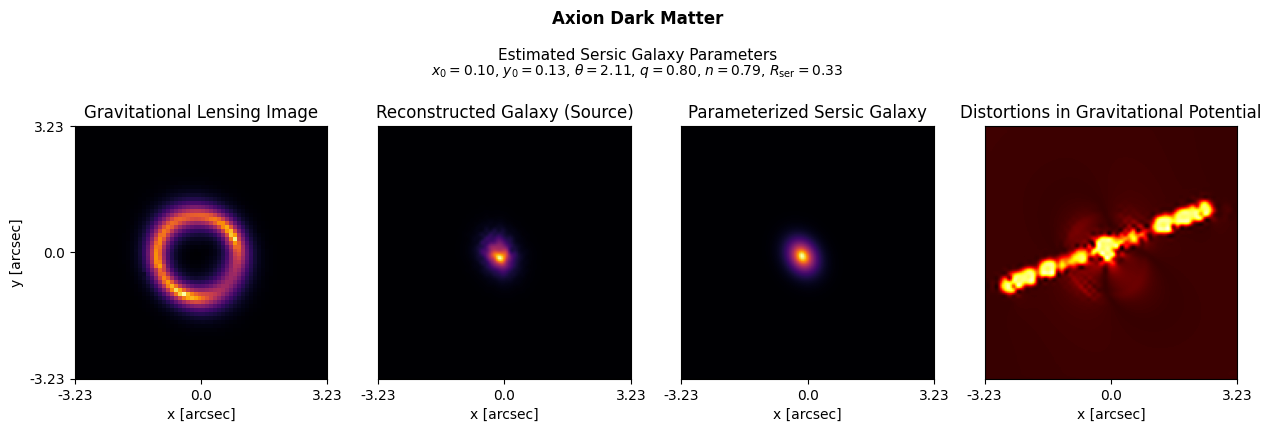

In [39]:



for image in images: # For each image in our list of images

  image_profile = image['img'] # Extract the image profile from the image dictionary
  kind = image['kind'] # Extract the kind or type of the image from the image dictionary

  # Use the function 'reconstruct_source' from the physics module to reconstruct the source of the image profile
  reconstruct_source = physics.reconstruct_source(image_profile,k=1)

  # Use the function 'parameterize_reconstructed_source' from the physics module to get the Sersic parameters
  # and estimated source profile
  sersic_params, estimated_source_profile = physics.parameterize_reconstructed_source(reconstruct_source)

  # Use the function 'estimate_distorsions_in_gravitational_potential' from the physics module to get the estimated gravitational distortions
  gravitational_distorsions = physics.estimate_distorsions_in_gravitational_potential(image_profile,
                                                                                      sersic_params,
                                                                                      post_process=True)

  # Improve the resolution of the reconstructed source, estimated source profile and gravitational distortions
  reconstruct_source_better_resolution = physics.improve_resolution(reconstruct_source)
  estimated_source_profile_better_resolution = physics.improve_resolution(estimated_source_profile)
  gravitational_distorsions_better_resolution = physics.improve_resolution(gravitational_distorsions)

  # Plot the features of the image, including the better resolution reconstructed source,
  # estimated source profile, and gravitational distortions, and also the Sersic parameters
  physics.plot_features(image_profile,
                        reconstruct_source_better_resolution,
                        estimated_source_profile_better_resolution,
                        gravitational_distorsions_better_resolution,
                        sersic_params,
                        main_title = f'{kind}') # The title of the plot will be the kind of the image
